<a href="https://colab.research.google.com/github/dpshepherd/PHY333_S2022/blob/main/Lab_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using python to analyze time varying signals

Two goals for this analysis:
1. Fit both channel A and channel B to $f(t) = Asin(\omega t + \phi)$. We expect that $\omega$ will be the same and there will be a $\frac{pi}{2}$ phase shift between the two signals.
2. Numerically differentiate channel A. We expect that $\frac{dA}{dt}$ should yield the signal on channel B.

## Setup python packages

### Import numpy for calculations,  matplotlib for plotting, and scipy for data fitting

In [1]:
pip install scipy --upgrade

In [2]:
import numpy as np # for math operations
import matplotlib.pyplot as plt # for plotting data
from scipy.odr import Model, RealData, ODR # for fitting data
import scipy.integrate as integrate  # for numerical integration 
import pandas as pd # for importing data files from picoScope software

## Load data from lab 2-2

#### Data is in a CSV file generated by the picoScope program.

We will use the [pandas](https://pandas.pydata.org/) library to load the data.

Example data can be downloaded [here](https://github.com/dpshepherd/PHY333_S2022/blob/00d82a96d3effd55f756ef95bc81e42928de8adf/Lab2data.zip). You'll need to download it, then unzip it on your local computer. 

Then click the "folder" icon to the left. You can then drag and drop the file into to storage for this Google Colab session. 

Once the file is uploaded, click the right dots to the right of the file and copy the file path.
  

In [3]:
# paste file path here. Make sure there are quotes around the filename.
file_path = "/content/5 microseconds 100kHz sine txt_01.txt"

# load the data. Check if the datafile it tab separated or comma separated
if file_path.endswith('.txt'):
  df_data = pd.read_csv(file_path, sep='\t')
elif file_path.endswith('.csv'):
  df_data = pd.read_csv(file_path)

### Inspect loaded data

The data is now formatted as a Pandas "dataframe". This looks somewhat like a spreadsheet.

Notice that the units are different for Channel A and Channel B. And that Time is in microseconds. We will need to be careful about units as we proceed with the analysis.

In [4]:
df_data

,Time,Channel A,Channel B
0,(us),(V),(mV)
1,-25.02248935,0.67384870,-258.29340000
2,-25.00248935,0.62883390,-258.29340000
3,-24.98248935,0.58397170,-258.29340000
4,-24.96248935,0.49409470,-258.29340000
...,...,...,...
2500,24.95751034,-0.35966060,-262.84060000
2501,24.97751034,-0.40467540,-267.37270000
2502,24.99751034,-0.44953760,-267.37270000
2503,25.01751034,-0.53941460,-262.84060000


### Extract data into numpy arrays

We need to get the data out of the Pandas dataframe into numpy arrays for calculations. We will convert to SI units at the same time.

In [5]:
# remove first row of datafrme to drop cells that contain unit information
df_data_cleaned = df_data.drop(0)

# extract data
time_values = df_data_cleaned['Time'].to_numpy(dtype=np.float) * 1e-6 # s
channel_A_values = df_data_cleaned['Channel A'].to_numpy(dtype=np.float) # V
channel_B_values = df_data_cleaned['Channel B'].to_numpy(dtype=np.float) * .001 # convert to V


#### Measurement uncertainity

[picoScope manual](https://www.picotech.com/download/datasheets/picoscope-2000-series-data-sheet-en.pdf)

Vertical and horizontal specifications are on page 16 and 17 of the PDF.

<u>Time</u>: 30 ps RMS typical

<u>Voltage</u>: ±3% of full scale ±200 μV

In [6]:
# you need to record the "full range" from the picoScope software.
channel_A_full_scale = 10 # unit: V
channel_B_full_scale = 1. # unit: V

# calculate uncertainity for voltage. 
# Equation is [voltage_values] + (full_scale_voltage)*.0003+.2e-6
channel_A_uncertainities = np.round(channel_A_full_scale*.0003 + (.2*10**-6),6) # unit: V
channel_B_uncertainities = np.round(channel_B_full_scale*.0003 + (.2*10**-6),6) # unit: V

# calculate uncertainity for time. Spec says says constants RMS of 30 ps 
time_uncertainity = 30*1e-12 # units: s

### Plot measurements with uncertainities

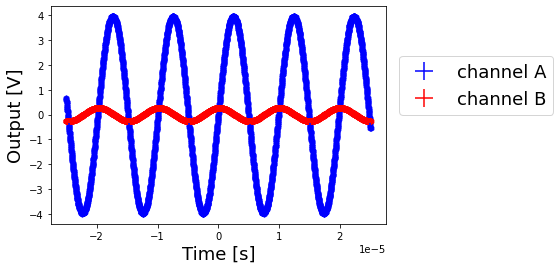

In [7]:
plt.errorbar(x=time_values,y=channel_A_values,xerr=time_uncertainity,yerr=channel_A_uncertainities,ls='none',label='channel A',color='b')
plt.scatter(time_values, channel_A_values, s = 30, marker = "h", color = "b")

plt.errorbar(x=time_values,y=channel_B_values,xerr=time_uncertainity,yerr=channel_B_uncertainities,ls='none',label='channel B',color='r')
plt.scatter(time_values, channel_B_values, s = 30, marker = "h", color = "r")

plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Output [V]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

## Analysis #1: determine phase angles

### Create function to fit  data and performparameter optimization for $f(t) = Asin(\omega t + \phi)$

In [8]:
# y = A*sin(omega*t+phi)
# parameters[0] -> amplitude (A)
# parameters[1] -> frequency (omega)
# parameters[2] -> phase (phi)

def function(parameters, time_values):

    A = parameters[0]
    omega = parameters[1]
    phi = parameters[2]

    model = A*np.sin(omega*time_values+phi)

    return model

### Create ODR model and data structures for fitting

In [9]:
linear_model = Model(function)
experimental_data_channel_A = RealData(time_values,channel_A_values,sx=time_uncertainity,sy=channel_A_uncertainities)
experimental_data_channel_B = RealData(time_values,channel_B_values,sx=time_uncertainity,sy=channel_B_uncertainities)

### Run fitting for Channel A


In [10]:
linear_odr = ODR(experimental_data_channel_A, linear_model, beta0=[channel_A_full_scale, 1e6,0])
ouptut_linear_odr = linear_odr.run()

### Extract results of the fitting for Channel A

Remember that $\omega = 2\pi f$ and $\phi$ is in returned radians. 

In [11]:
# Extract fits and uncertainities from fitting program
A_channelA = ouptut_linear_odr.beta[0]
dA_channelA = ouptut_linear_odr.sd_beta[0]
omega_channelA = ouptut_linear_odr.beta[1]
domega_channelA = ouptut_linear_odr.sd_beta[1]
phi_channelA = ouptut_linear_odr.beta[2]
dphi_channelA = ouptut_linear_odr.sd_beta[2]

In [12]:
print('Channel A results')
print('-----------------')
print('Amplitude (V) = ' + str(np.round(A_channelA,2)) + ' +/- ' + str(np.round(dA_channelA,2)))
print('Frequency (Hz) = ' + str(np.round(omega_channelA/(2*np.pi),2)) + ' +/- ' + str(np.round(domega_channelA/(2*np.pi),2)))
print('Phi (degrees) = ' + str(np.round(phi_channelA/(2*np.pi)*360.,2)) + ' +/- ' + str(np.round(dphi_channelA/(2*np.pi)*360.,2)))

Channel A results
-----------------
Amplitude (V) = 3.98 +/- 0.0
Frequency (Hz) = 100856.75 +/- 1.93
Phi (degrees) = -0.74 +/- 0.01


### Run fitting for Channel B

In [13]:
linear_odr = ODR(experimental_data_channel_B, linear_model, beta0=[channel_B_full_scale, 1e6,np.pi/2])
ouptut_linear_odr = linear_odr.run()

### Extract results of the fitting for Channel A

Remember that $\omega = 2\pi f$ and $\phi$ is in returned radians. 

In [14]:
# Extract fits and uncertainities from fitting program
A_channelB = ouptut_linear_odr.beta[0]
dA_channelB = ouptut_linear_odr.sd_beta[0]
omega_channelB = ouptut_linear_odr.beta[1]
domega_channelB = ouptut_linear_odr.sd_beta[1]
phi_channelB = ouptut_linear_odr.beta[2]
dphi_channelB = ouptut_linear_odr.sd_beta[2]

In [15]:
print('Channel B results')
print('-----------------')
print('Amplitude (V) = ' + str(np.round(A_channelB,2)) + ' +/- ' + str(np.round(dA_channelB,2)))
print('Frequency (Hz) = ' + str(np.round(omega_channelB/(2*np.pi),2)) + ' +/- ' + str(np.round(domega_channelB/(2*np.pi),2)))
print('Phi (degrees) = ' + str(np.round(phi_channelB/(2*np.pi)*360.,2)) + ' +/- ' + str(np.round(dphi_channelB/(2*np.pi)*360.,2)))

Channel B results
-----------------
Amplitude (V) = 0.27 +/- 0.0
Frequency (Hz) = 100866.04 +/- 6.13
Phi (degrees) = 83.55 +/- 0.03


### We find that $\omega_B - \omega_A \approx0$ Hz and $\phi_B - \phi_A \approx83$ degrees. This close to our expectations.

## Analysis #2: numerical differentiation and integration

### Calculate numerical derivative of Channel A data and compare to Channel B

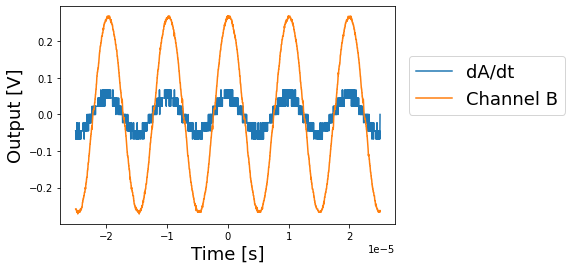

In [36]:
# use numpy.gradient to calculate numerical derivative
dAdt = np.gradient(channel_A_values)

plt.plot(time_values,dAdt,label='dA/dt')
plt.plot(time_values,channel_B_values,label='Channel B')

plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Output [V]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

### Calculate numerical integral of Channel B data and compare to Channel A

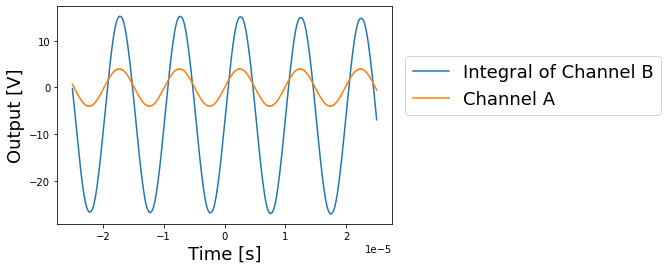

In [35]:
# use scipy.integrate.cumulative_trapezoid to calculate cumulative numerical integration
integral_B = integrate.cumulative_trapezoid(y=channel_B_values)

plt.plot(time_values[0:-1],integral_B,label='Integral of Channel B')
plt.plot(time_values,channel_A_values,label='Channel A')

plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('Output [V]', fontsize=18)
plt.legend(loc=(1.04,.5),fontsize=18)
plt.show()

### Question for you: why do the amplitudes not match? What are we missing in these models?